In [3]:
using Pkg
Pkg.DEFAULT_IO[] = stdout  # Julia 1.6.1 bug (Pkg.jl#2542)
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Julia/doc/cscs_gpu_course`


# Programming models

There are different ways of programming (NVIDIA) GPUs in Julia, at different levels of abstraction.

## Array programming

The easiest way to use a GPU is via vectorized array operations. Each of these operations will be backed by one or more GPU kernels, either natively written in Julia or from some application library. As long as your data is large enough you'll should be able to get some nice speed-ups.

For NVIDIA GPUs, you use the `CuArray` type from CUDA.jl, which serves a dual porpose:
- a managed container for GPU memory
- a way to dispatch to operations that execute on the GPU

In [4]:
using CUDA
A = CuArray([1. 2.; 3. 4.])

2×2 CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}:
 1.0  2.0
 3.0  4.0

Memory management will be discussed in detail in a next notebook, but for now it's enough to remember that a CuArray is **a CPU object representing memory on the GPU**. It will be automatically freed when all references have been removed, and the garbage collector runs.

The goal of `CuArray` is to make it easy to program GPUs using array operations:

In [5]:
# this will automatically use CUBLAS
A * A

2×2 CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}:
  7.0  10.0
 15.0  22.0

In [6]:
# whereas this operation will use a native broadcast kernel
A .* A

2×2 CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}:
 1.0   4.0
 9.0  16.0

This works by specializing certain methods with a GPU-specialized implementation, either for:
- compatibility: not all CPU implementations work on the GPU
- performance: GPUs have a different programming model so might require optimized implementations

This generally works pretty well, the goal is to get as close to the CPU `Array` type's functionality as possible, and entire applications have been built on top of CuArray's array functionality. So instead let's highlight what can go wrong if you don't call into a GPU-specialized implementation where you need one.

### Compatibility: Calling into C libraries

A common issue arises when calling CPU-specific code, e.g. in some C library, using a GPU array. This generally does not work, because GPU pointers are not dereferencable on the CPU. To prevent this from crashing, we introduce a GPU-specific pointer type and disallow conversions:

In [7]:
ccall(:whatever, Nothing, (Ptr{Float32},), A)

LoadError: ArgumentError: cannot take the CPU address of a CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}

In that case, either you need to use different (supported) array operations, or fix the implementation in CUDA.jl. Such a fix can mean using functions from a CUDA library, using existing operations, or writing your own kernel.

### Performance: Scalar iteration

A key performance issue comes from the fact that a `CuArray` instance is a CPU object representing a chunk of memory on the GPU. That means we invoke the GPU for every CPU operation invoked on a CuArray. That is OK for scalar invocations, where the GPU operation will have to do a bunch of work, but is very bad when you have CPU code performing a bunch of small scalar operations:

In [8]:
A = CuArray(1:10)
A_sum = zero(eltype(A))
for I in eachindex(A)
    A_sum += A[I]
end
A_sum

┌ Warning: Performing scalar indexing on task Task (runnable) @0x00007fa642362290.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore are only permitted from the REPL for prototyping purposes.
│ If you did intend to index this array, annotate the caller with @allowscalar.
└ @ GPUArrays /home/tim/Julia/depot/packages/GPUArrays/3sW6s/src/host/indexing.jl:56


55

Because of this kind of programming pattern, iterating the array and fetching one scalar at a time (hence 'scalar iteration'), being so slow CUDA.jl warns about it. With the above snippet, the situation is actually even worse: Not only does every iteration require a GPU operation to fetch an element, the `getindex` call is also the only array operation meaning that the actual summation won't even run on the GPU!

The solution here is to use the `sum` function that performs the entire operation as a single step. More on these operations later.
To disallow scalar iteration, use the `allowscalar` function:

In [9]:
CUDA.allowscalar(false)
A[1]

LoadError: Scalar indexing is disallowed.
Invocation of getindex resulted in scalar indexing of a GPU array.
This is typically caused by calling an iterating implementation of a method.
Such implementations *do not* execute on the GPU, but very slowly on the CPU,
and therefore are only permitted from the REPL for prototyping purposes.
If you did intend to index this array, annotate the caller with @allowscalar.

You should generally always enable this option! It's not by default in interactive sessions because it simplifies porting CPU code, and it's easy to trigger scalar iteration from non performance-sensitive paths (e.g. display methods):

In [10]:
A'

1×10 adjoint(::CuArray{Int64, 1, CUDA.Mem.DeviceBuffer}) with eltype Int64:
 1  2  3  4  5  6  7  8  9  10

In [11]:
view(A', :, :)

ErrorException: Scalar indexing is disallowed.
Invocation of getindex resulted in scalar indexing of a GPU array.
This is typically caused by calling an iterating implementation of a method.
Such implementations *do not* execute on the GPU, but very slowly on the CPU,
and therefore are only permitted from the REPL for prototyping purposes.
If you did intend to index this array, annotate the caller with @allowscalar.

Because of how Julia's type system works, it's easy to trigger non GPU-specialized methods when using array wrappers. Still, for non-interactive code it's recommended to always disable scalar iteration.

### CuArray isn't device-compatible

A more subtle result of `CuArray` being the CPU-side object is that these objects cannot be used directly on the GPU. Instead, a conversion to `CuDeviceArray` happens:

In [12]:
@device_code_warntype @cuda (A->nothing)(A)

PTX CompilerJob of kernel #2(CuDeviceVector{Int64, 1}) for sm_75

MethodInstance for (::var"#2#3")(::CuDeviceVector{Int64, 1})
  from (::var"#2#3")(A) in Main at In[12]:1
Arguments
  #self#::Core.Const(var"#2#3"())
  A::CuDeviceVector{Int64, 1}
Body::Nothing
1 ─     return Main.nothing



Typically, this conversion is hidden and shouldn't affect you as an end user. The only time you need to take care, is when embedding `CuArray`s in a structure:

In [13]:
struct MyStruct
    inner::CuArray
end
B = MyStruct(A)
@cuda (A->nothing)(B)

LoadError: GPU compilation of kernel #4(MyStruct) failed
KernelError: passing and using non-bitstype argument

Argument 2 to your kernel function is of type MyStruct, which is not isbits:
  .inner is of type CuArray which is not isbits.
    .storage is of type Union{Nothing, CUDA.ArrayStorage{B}} where B which is not isbits.
    .dims is of type Tuple{Vararg{Int64, N}} where N which is not isbits.



Here, CUDA.jl makes it clear that a `CuArray` isn't GPU compatible because it's not an `isbits` type. The underlying reason is that the automatic conversion from `CuArray` to `CuDeviceArray` doesn't know about your `MyStruct` and how to convert it to something GPU-compatible. This conversion is done using Adapt.jl, and to make this code work you need to teach Adapt about how to convert `MyStruct` objects:

In [14]:
# to store both a CuArray and a CuDeviceArray
# our struct needs to be parametric
struct MyParametricStruct{T<:AbstractArray}
    inner::T
end

using Adapt
Adapt.adapt_structure(to, x::MyParametricStruct) = MyParametricStruct(adapt(to, x.inner))

C = MyParametricStruct(A)
@device_code_warntype @cuda (A->nothing)(C)

PTX CompilerJob of kernel #6(MyParametricStruct{CuDeviceVector{Int64, 1}}) for sm_75

MethodInstance for (::var"#6#7")(::MyParametricStruct{CuDeviceVector{Int64, 1}})
  from (::var"#6#7")(A) in Main at In[14]:11
Arguments
  #self#::Core.Const(var"#6#7"())
  A::MyParametricStruct{CuDeviceVector{Int64, 1}}
Body::Nothing
1 ─     return Main.nothing



In [ ]:
A = rand(1024, 1024)
B = rand(1024, 1024)
sqrt(sum((A-B).^2) / length(A))

## Kernel programming

When an array operation is not supported, or you need to perform an operation that you can easily express using existing array abstractions, you might need to write your own kernel. Kernels are **scalar functions that are executed multiple times in parallel**. Each 'thread' runs on one of the many streaming multiprocessors a GPU has, and threads running on a single SM are called a 'block'. Within a SM, some threads are always executed together; these form a 'warp' of 32 threads. Efficient communication between these entities is required to effectively use the GPU:

- between blocks: global memory
- within a block: shared memory
- within a warp: via registers (shuffle)

Within kernels, most of the Julia language is supported, with the exception of functionality that requires the Julia runtime library. That does mean you cannot allocate memory, or perform dynamic function calls, both of which are easy to do accidentally.

At the same time, there are some special functions that only work in kernel context. Let's start by discussing those.

### Hardware indices

You can fetch the thread, block and warp index using specific functions that query hardware indices:

- `threadIdx()` and `blockDim()`: 3D
- `blockIdx()` and `gridDim()`: 3D
- `laneid()` and `warpsize()`

When you don't need to care about which block a thread is part of, a very common index calculation is as follows:

In [16]:
function kernel()
    i = (blockIdx().x-1) * blockDim().x + threadIdx().x
    @cushow i
    return
end
@cuda threads=2 blocks=2 kernel();

i = 1
i = 2
i = 3
i = 4


### Synchronization

If threads are working together -- say, they are using the same global memory, or are communicating using shared memory or finer-grained intrinsics -- you may need to have threads wait on each other. Note that this is only possible **within a block**; different blocks generally cannot wait on one another.

Let's look at a contrived example:

In [17]:
A = CUDA.zeros(512)

function kernel(A)
    # simple kernel without multiple blocks
    i = threadIdx().x
    
    # first thread sets up the data
    if i == 1
        A[1] = 42
    end
    
    sync_threads()
    
    # other threads can now read this data
    if i != 1
        A[i] = A[1]
    end
    
    return
end
@cuda threads=length(A) kernel(A)
unique(Array(A))

i = 1
i = 2
i = 3
i = 4


1-element Vector{Float32}:
 42.0

Note how we didn't put `sync_threads()` inside of the branch; All threads need to reach the synchronization point for the kernel to make progress. This makes it dangerous to synchronize from a branch, as the branch cannot be divergent within a block or the kernel would deadlock!

When coordinating within the warp, you may need the `sync_warp()` function. A detailed explanation of warp-level programming is out of scope for this notebook, refer to the [NVIDIA developer blog](https://developer.nvidia.com/blog/using-cuda-warp-level-primitives/) for more information.

### Atomic operations

When you want to use the same global memory from different threads, you may want to use atomic operations. For example:

In [19]:
A_sum = CUDA.zeros(1)
A = CUDA.rand(512)

function kernel(A, A_sum)
    i = threadIdx().x
    CUDA.@atomic A_sum[] += A[i]
    return
end
@cuda threads=length(A) kernel(A, A_sum)
Array(A_sum)[]

239.7315f0

You shouldn't overuse atomics though, as they generally serialize execution and thus are very expensive! But they may be useful for an initial implementation (i.e. before considering more fine-grained communication), or to reduce values from different blocks (because of the difficulty of synchronizing the grid).

### Output

To help with implementing a kernel, there's a couple of helpful macros to generate output:

In [22]:
function kernel()
    i = threadIdx().x
    @cuprintf "I'm thread %ld\n" Int(i)
    return
end
@cuda kernel();

I'm thread 1


However, `@cuprintf` is a bit cumbersome, so we have `@cuprintln` trying to automatically generate an appropriate formatting string, while even supporting string interpolation:

In [24]:
function kernel()
    i = threadIdx().x
    @cuprintln "I'm thread $i"
    return
end
@cuda kernel();

I'm thread 1


And for quick debugging, we have a helpful `@cushow` you can surround expressions with:

In [26]:
function kernel()
    i = @cushow(threadIdx().x)
    return
end
@cuda kernel();

(threadIdx()).x = 1


## When things go wrong

Because some aspects of the Julia language are unsupported, you'll definitely be running into compilation errors when writing GPU device code. With CPU code, Julia being a dynamic language, errors are postponed to run-time, so if you have a typo in your code it will still compile but you will run into an error at run time.

With GPU code, it's harder to report errors at run time (for one, they'd be generated by every thread, resulting in a multiplication of errors), so the GPU compiler generally refuses to compile when it encounters certain unsupported code patterns.

<div class="alert alert-block alert-info">
    <b>Note</b>: Work is under way to improve the ability for GPU code to call into the CPU for, e.g., dynamic error reporting. That would make it possible to compile unsupported code and have it error at run time just like Julia code on the CPU.
</div>

Let's demonstrate a couple of common errors:

### Returning values from kernels

Kernel functions cannot return anything; if you do so you'll run into a compilation error:

In [27]:
kernel() = 42
@cuda kernel()

(threadIdx()).x = 1


LoadError: GPU compilation of kernel kernel() failed
KernelError: kernel returns a value of type `Int64`

Make sure your kernel function ends in `return`, `return nothing` or `nothing`.
If the returned value is of type `Union{}`, your Julia code probably throws an exception.
Inspect the code with `@device_code_warntype` for more details.


That's easy enough, but as the error message hints to you can run into this error in an unexpected way:

In [28]:
function kernel()
    throw(42)
    return
end
@cuda kernel()

LoadError: GPU compilation of kernel kernel() failed
KernelError: kernel returns a value of type `Union{}`

Make sure your kernel function ends in `return`, `return nothing` or `nothing`.
If the returned value is of type `Union{}`, your Julia code probably throws an exception.
Inspect the code with `@device_code_warntype` for more details.


Even though we have a `return` at the end of our kernel, because of the unconditional throw a value of type `Union{}` is returned (the bottom type in the type lattice). As a result, any kernel that Julia figures out to be unconditionally throwing will trigger this error, a red herring for the actual problem with your kernel. For example:

In [29]:
function kernel(a)
    if threadIdx().X == 1
        a[] = 42
    end
    return
end
@cuda kernel(CuArray([1]))

LoadError: GPU compilation of kernel kernel(CuDeviceVector{Int64, 1}) failed
KernelError: kernel returns a value of type `Union{}`

Make sure your kernel function ends in `return`, `return nothing` or `nothing`.
If the returned value is of type `Union{}`, your Julia code probably throws an exception.
Inspect the code with `@device_code_warntype` for more details.


The unconditional throw happens because we have a typo: `threadIdx().X` instead of `threadIdx().x`. Julia's compiler detects this, and unconditionally lowers this to an exception. You can spot this with the CUDA.jl's code reflection macros, showing that the `getproperty` call is the last evaluated expression before everything devolves into a constant `Union{}`:

<div class="alert alert-block alert-info">
    <b>Note</b>: Accurate reporting requires Julia 1.7.
</div>

In [31]:
@device_code_warntype @cuda kernel(CuArray([1]))

PTX CompilerJob of kernel kernel(CuDeviceVector{Int64, 1}) for sm_75

MethodInstance for kernel(::CuDeviceVector{Int64, 1})
  from kernel(a) in Main at In[29]:1
Arguments
  #self#::Core.Const(kernel)
  a::CuDeviceVector{Int64, 1}
Body::Union{}
1 ─ %1 = Main.threadIdx()::NamedTuple{(:x, :y, :z), Tuple{Int32, Int32, Int32}}
│        Base.getproperty(%1, :X)
│        Core.Const(:(%2 == 1))
│        Core.Const(:(Core.typeassert(%3, Core.Bool)))
│        Core.Const(:(Base.setindex!(a, 42)))
└──      Core.Const(:(return nothing))



LoadError: GPU compilation of kernel kernel(CuDeviceVector{Int64, 1}) failed
KernelError: kernel returns a value of type `Union{}`

Make sure your kernel function ends in `return`, `return nothing` or `nothing`.
If the returned value is of type `Union{}`, your Julia code probably throws an exception.
Inspect the code with `@device_code_warntype` for more details.


<div class="alert alert-block alert-info">
    <b>Note</b>: When the error occurs in a child function, and not in the kernel itself, it can be difficult to spot the issue. It used to be possible to use Cthulhu.jl to interactively inspect the code generated for child functions, but that functionality is currently broken. Awaiting a fix, you can manually inspect code generated for a child function by using `CUDA.code_warntype`.
</div>

In [32]:
kernel(a) = child(a)
@noinline child(a) = a[] = threadIdx().X
@device_code_warntype @cuda kernel(CuArray([1]))

PTX CompilerJob of kernel kernel(CuDeviceVector{Int64, 1}) for sm_75

MethodInstance for kernel(::CuDeviceVector{Int64, 1})
  from kernel(a) in Main at In[32]:1
Arguments
  #self#::Core.Const(kernel)
  a::CuDeviceVector{Int64, 1}
Body::Union{}
1 ─     Main.child(a)
└──     Core.Const(:(return %1))



LoadError: GPU compilation of kernel kernel(CuDeviceVector{Int64, 1}) failed
KernelError: kernel returns a value of type `Union{}`

Make sure your kernel function ends in `return`, `return nothing` or `nothing`.
If the returned value is of type `Union{}`, your Julia code probably throws an exception.
Inspect the code with `@device_code_warntype` for more details.


In [33]:
CUDA.code_warntype(child, (CuDeviceVector{Int64, 1},))

MethodInstance for child(::CuDeviceVector{Int64, 1})
  from child(a) in Main at In[32]:2
Arguments
  #self#::Core.Const(child)
  a::CuDeviceVector{Int64, 1}
Body::Union{}
1 ─      $(Expr(:meta, :noinline))
│   %2 = Main.threadIdx()::NamedTuple{(:x, :y, :z), Tuple{Int32, Int32, Int32}}
│        Base.getproperty(%2, :X)
│        Core.Const(:(Base.setindex!(a, %3)))
└──      Core.Const(:(return %3))



<div class="alert alert-block alert-info">
    <b>Note</b>: When using the non-macro versions of reflection utilities, you need to specify device-side types. For example, to inspect a kernel taking a `CuArray` you will need to specify `CuDeviceVector`.
</div>

### Unsupported IR

Other errors might result in a failure later during compilation:

In [34]:
function kernel(a)
    if threadId().x == 1
        a[] = 42
    end
    return
end
@cuda kernel(CuArray([1]))

LoadError: InvalidIRError: compiling kernel kernel(CuDeviceVector{Int64, 1}) resulted in invalid LLVM IR
Reason: unsupported use of an undefined name (use of 'threadId')
Stacktrace:
 [1] [0m[1mkernel[22m
[90m   @ [39m[90m./[39m[90m[4mIn[34]:2[24m[39m
Reason: unsupported dynamic function invocation
Stacktrace:
 [1] [0m[1mkernel[22m
[90m   @ [39m[90m./[39m[90m[4mIn[34]:2[24m[39m
Reason: unsupported dynamic function invocation (call to getproperty)
Stacktrace:
 [1] [0m[1mkernel[22m
[90m   @ [39m[90m./[39m[90m[4mIn[34]:2[24m[39m
Reason: unsupported dynamic function invocation (call to ==)
Stacktrace:
 [1] [0m[1mkernel[22m
[90m   @ [39m[90m./[39m[90m[4mIn[34]:2[24m[39m

CUDA.jl tries its best to figure out why dynamic IR was generated, as can be seen in the error trace here. But again, we're also able to spot this error using reflection macros:

In [35]:
@device_code_warntype @cuda kernel(CuArray([1]))

PTX CompilerJob of kernel kernel(CuDeviceVector{Int64, 1}) for sm_75

MethodInstance for kernel(::CuDeviceVector{Int64, 1})
  from kernel(a) in Main at In[34]:1
Arguments
  #self#::Core.Const(kernel)
  a::CuDeviceVector{Int64, 1}
Body::Nothing
1 ─ %1 = Main.threadId()::Any
│   %2 = Base.getproperty(%1, :x)::Any
│   %3 = (%2 == 1)::Any
└──      goto #3 if not %3
2 ─      Base.setindex!(a, 42)
3 ┄      return nothing



LoadError: InvalidIRError: compiling kernel kernel(CuDeviceVector{Int64, 1}) resulted in invalid LLVM IR
Reason: unsupported use of an undefined name (use of 'threadId')
Stacktrace:
 [1] [0m[1mkernel[22m
[90m   @ [39m[90m./[39m[90m[4mIn[34]:2[24m[39m
Reason: unsupported dynamic function invocation
Stacktrace:
 [1] [0m[1mkernel[22m
[90m   @ [39m[90m./[39m[90m[4mIn[34]:2[24m[39m
Reason: unsupported dynamic function invocation (call to getproperty)
Stacktrace:
 [1] [0m[1mkernel[22m
[90m   @ [39m[90m./[39m[90m[4mIn[34]:2[24m[39m
Reason: unsupported dynamic function invocation (call to ==)
Stacktrace:
 [1] [0m[1mkernel[22m
[90m   @ [39m[90m./[39m[90m[4mIn[34]:2[24m[39m

In this IR, the `::Any` indicates that type-unstable code will be generated. This is unsupported on the GPU, as it will result in calls to the runtime library.

### Passing invalid types

Compilation errors are not limited to kernel functions, you can trigger some by using array abstractions in an invalid manner. For example:

In [36]:
CuArray([1]) .= [1]

LoadError: GPU compilation of kernel broadcast_kernel(CUDA.CuKernelContext, CuDeviceVector{Int64, 1}, Base.Broadcast.Broadcasted{Nothing, Tuple{Base.OneTo{Int64}}, typeof(identity), Tuple{Base.Broadcast.Extruded{Vector{Int64}, Tuple{Bool}, Tuple{Int64}}}}, Int64) failed
KernelError: passing and using non-bitstype argument

Argument 4 to your kernel function is of type Base.Broadcast.Broadcasted{Nothing, Tuple{Base.OneTo{Int64}}, typeof(identity), Tuple{Base.Broadcast.Extruded{Vector{Int64}, Tuple{Bool}, Tuple{Int64}}}}, which is not isbits:
  .args is of type Tuple{Base.Broadcast.Extruded{Vector{Int64}, Tuple{Bool}, Tuple{Int64}}} which is not isbits.
    .1 is of type Base.Broadcast.Extruded{Vector{Int64}, Tuple{Bool}, Tuple{Int64}} which is not isbits.
      .x is of type Vector{Int64} which is not isbits.



Here, compilation fails because GPU code requires all arguments to be `isbits` (remember the difference between `CuArray` and `CuDeviceArray`).

### Run-time exceptions

Finally, to demonstrate that we _are_ working on dynamic error semantics: Some exceptions are already being reported at run time:

In [37]:
function kernel(a)
    if threadIdx().x == 1
        a[] += 42.1
    end
    return
end
@cuda kernel(CuArray([42]))
device_synchronize()

ERROR: a exception was thrown during kernel execution.
       Run Julia on debug level 2 for device stack traces.


LoadError: KernelException: exception thrown during kernel execution on device Quadro RTX 5000

When such a run-time exception happens, the GPU will print, and any subsequent synchronization API call will fail and report the exception on the host too. For more information on the error, launch Julia with `-g2`:

```
$ julia -g2
...
julia> @cuda kernel(CuArray([42]))
ERROR: a exception was thrown during kernel execution.
Stacktrace:
 [1] Int64 at ./float.jl:812
 [2] convert at ./number.jl:7
 [3] setindex! at /home/tim/Julia/pkg/CUDA/src/device/array.jl:204
 [4] setindex! at /home/tim/Julia/pkg/CUDA/src/device/array.jl:217
 [5] kernel at ./REPL[1]:3
```

## Exercise: Matrix RMSE

With all that out of the way, time for an exercise: Try to compute the RMSE of two matrices on the GPU using both array operations and using a GPU kernel (a single kernel, if possible):

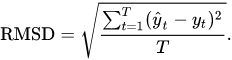

For prototyping, you can develop the array operation on the CPU (one of the advantages of using array operations):

In [39]:
A = rand(10,10)
B = rand(10,10)
sqrt(sum((A-B).^2) / length(A))

0.4371607137189118

To 'port' this to the GPU, just change the type of the input arrays to `CuArray` and the computation of C just works:

In [42]:
A = CuArray(A)
B = CuArray(B)
sqrt(sum((A-B).^2) / length(A))

0.4371607137189118

Now for a CUDA.jl kernel:

In [43]:
function rmse_kernel(C, A, B)  
    i = threadIdx().x

    # initialize the memory
    if i == 1
        C[] = 0
    end
    sync_threads()
    
    # process an element on each thread
    a = A[i]
    b = B[i]
    CUDA.@atomic C[] += (a-b)^2
    sync_threads()
    
    # finalize the computation
    if i == 1
        C[1] = sqrt(C[] / length(A))
    end
    return
end

C = similar(A, 1)
@cuda threads=length(A) rmse_kernel(C, A, B)
C

1-element CuArray{Float64, 1, CUDA.Mem.DeviceBuffer}:
 0.43716071371891185

This kernel only works when the array fits in a single block though:

In [44]:
A = CUDA.rand(1024,1024)
B = CUDA.rand(1024,1024)
@cuda threads=length(A) rmse_kernel(C, A, B)

LoadError: CUDA error: invalid argument (code 1, ERROR_INVALID_VALUE)

We could just use multiple blocks, since our currently implementation doesn't use any communication between threads. However, in a future notebook we _will_ add such communication, so for now let's make it so that we only need a single block to process this matrix.

A good way to do so is to introduce a grid-stride loop. This has been explained in a previous notebook, so try adapting the kernel implementation:

In [45]:
function rmse_kernel(C, A, B)  
    # initialize the memory
    if threadIdx().x == 1
        C[1] = 0
    end
    sync_threads()
    
    # grid-stride loop to process each batch in a block
    for i in threadIdx().x:blockDim().x:length(A)
        a = A[i]
        b = B[i]
        CUDA.@atomic C[1] += (a-b)^2
    end    
    sync_threads()
    
    # finalize the computation
    if threadIdx().x == 1
        C[1] = sqrt(C[1] / length(A))
    end
    return
end

@cuda threads=256 rmse_kernel(C, A, B)
C

1-element CuArray{Float64, 1, CUDA.Mem.DeviceBuffer}:
 0.40806423281510307

In [46]:
using BenchmarkTools

In [47]:
@benchmark CUDA.@sync sqrt(sum((A-B).^2) / length(A))

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):   97.539 μs … 300.925 ms  ┊ GC (min … max): 0.00% … 1.58%
 Time  (median):     102.009 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   287.192 μs ±   6.707 ms  ┊ GC (mean ± σ):  0.70% ± 0.03%

  █▅        ▃▅▂▁▂▄▂▁  ▁                                         ▁
  ███▆▆▇▃▁▁████████████▇▆▆▅▇▇██▆▄▁▁▄▅▄▄▆▆▅▄▄▄▄▁▁▄▃▁▄▁▅▄▅▅▁▄▅▆▇▆ █
  97.5 μs       Histogram: log(frequency) by time        538 μs <

 Memory estimate: 4.62 KiB, allocs estimate: 91.

In [48]:
@benchmark CUDA.@sync @cuda threads=256 rmse_kernel(C, A, B)

BenchmarkTools.Trial: 2645 samples with 1 evaluation.
 Range (min … max):  1.790 ms …   2.676 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.814 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.887 ms ± 134.597 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▅█▆▃▄▅▅▂              ▂▃▃                 ▂▃▃▃▁             ▁
  █████████▇▅▅▃▃▄▃▄▄▃▅▆█████▇▄▄▆▆▁▆▆▅▆▅▄▆▃▁▆█████▆▆▇▃▅▆▆▇▇▆▆▅ █
  1.79 ms      Histogram: log(frequency) by time      2.26 ms <

 Memory estimate: 2.12 KiB, allocs estimate: 39.

## High-level kernel programming

There's a couple of packages that aim to simplify kernel programming without resorting to array operations (which may result in extraneous kernel launches, more on that in some of the next notebooks).

### Tullio.jl

With Tullio, it's easy to write kernels using index notation. This makes it easy to express operations like our RMSE calculation in a single expression which typically will also be compiled to a single kernel:

In [49]:
using Tullio

A = ones(10, 10)

# assigning with `:=` creates a new array
@tullio C[i,j] := A[i,j]

10×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [50]:
# dropping an index will sum across that dimension
@tullio C[i] := A[i,j]

10-element Vector{Float64}:
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0

In [51]:
# pipe operators can be used to apply functions 'outside' of the reduction
@tullio C[] := A[i,j] |> log10(_)

0-dimensional Array{Float64, 0}:
2.0

With that explained, try to implement the matrix RMSE operation using index notation. Recall the original operation (first on CPU arrays):

In [52]:
A = rand(1024, 1024)
B = rand(1024, 1024)
sqrt(sum((A-B).^2)/length(A))

0.40818387497936137

Now with Tullio:

In [53]:
@tullio C[] := (A[i,j] - B[i,j])^2 |> sqrt(_ / length(A))

0-dimensional Array{Float64, 0}:
0.40818387497935993

To use Tullio with GPU arrays, you need to install and import the relevant CUDA support packages:

In [54]:
using KernelAbstractions, CUDAKernels

In [56]:
A = CUDA.rand(Float64, 1024, 1024)
B = CUDA.rand(Float64, 1024, 1024)
@tullio C[] := (A[i,j] - B[i,j])^2 |> sqrt(_ / length(A))

0-dimensional CuArray{Float64, 0, CUDA.Mem.DeviceBuffer}:
0.4084786369073591

Tullio is great for quickly creating portable kernels (CPU, different GPU back-ends) for mathematical operations, and it can be seen as a generalization of broadcast.

### KernelAbstractions.jl

For a more flexible API, i.e. not restricted to Tullio's index notation, but still retaining Tullio's portability, you can consider the KernelAbstractions.jl framework that Tullio.jl is built on:

In [ ]:
using KernelAbstractions

In [57]:
@kernel function ka_kernel(A)
    # simple kernel without multiple blocks
    i = @index(Global, Linear)
    
    # first thread sets up the data
    if i == 1
        A[1] = 42
    end
    
    @synchronize()
    
    # other threads can now read this data
    if i != 1
        A[i] = A[1]
    end
end;

In [58]:
A = zeros(512)

the_ka_kernel = ka_kernel(CPU(), 16)
event = the_ka_kernel(A, ndrange=size(A))
wait(event)
unique(A)

2-element Vector{Float64}:
 42.0
  0.0

The programming interface is now much closer to CUDA.jl's, while retaining platform portability!

In [59]:
A = CUDA.zeros(512)
the_ka_kernel = ka_kernel(CUDADevice(), 16)
event = the_ka_kernel(A, ndrange=size(A))
wait(event)
unique(Array(A))

2-element Vector{Float32}:
 42.0
  0.0

The disadvantage of platform portability of course is that KernelAbstraction.jl's feature set is limited to the common denominator of all supported platforms. That means many CUDA features, like atomics or warp-level programming, are not supported. In addition, KernelAbstractions is built on Cassette.jl which will incur a significant compilation cost for nontrivial applications.

## Exercise: Batched matrix RMSE

To extend our RMSE example to something more interesting (that we will use in later notebooks), let's extend the computation of the RMSE between two matrices to a batched version that computes `N` RMSEs:

In [60]:
N = 16
A = CUDA.rand(1024, 1024, N)
B = CUDA.rand(1024, 1024, N)
CUDA.allowscalar(false)

In [61]:
rmse(A, B) = sqrt(sum((A-B).^2)/length(A))

rmses = Vector{Float64}(undef, N)
for i in 1:N
    rmses[i] = rmse(A[:, :, i], B[:, :, i])
end
rmses

16-element Vector{Float64}:
 0.4082169830799103
 0.4079669713973999
 0.4082328677177429
 0.40848812460899353
 0.40832608938217163
 0.40797746181488037
 0.40838271379470825
 0.4084061086177826
 0.408465176820755
 0.40836670994758606
 0.408399760723114
 0.40817853808403015
 0.40795910358428955
 0.40815645456314087
 0.4081289768218994
 0.408197820186615

This is a pretty bad implementation, but we'll have a look at optimizing it in a future notebook. For now, let's just focus on a correct implementation.

First, let's try to extend the Tullio expression to correctly handle the batch dimension:

In [62]:
@tullio C[k] := (A[i,j,k] - B[i,j,k])^2 |> sqrt(_ / (size(A,1)*size(A,2)))

16-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
 0.40810126
 0.40785328
 0.40811905
 0.4083677
 0.40820864
 0.40786406
 0.4082666
 0.40829465
 0.4083512
 0.40825215
 0.40828666
 0.40806714
 0.40784103
 0.4080411
 0.40802044
 0.40808234

Note the manual length computation because Tullio doesn't like an additional `prod(size(A)[1:2])`.

Next, try to extend the grid-stride kernel implementation to handle multiple batches. We could just launch our kernel `N` times, but let's try and handle the batching *inside* the kernel. The easiest way to do so, is to launch one block per batch and to fetch the batch number inside the kernel from the `blockIdx()` hardware indices.

That poses a problem though, as we were using a linear index whereas we now need 3 indices (x, y, and batch). There's multiple possible solutions:
- generalize indexing to cartesian indices
- launch 2-dimensional blocks, and extend the grid-stride loop to cover both dimensions
- reshape the input to a 2D matrix (i.e. flatten the matrix dimensions)

Let's start with reshaping, for simplicity:

In [63]:
A_flat = reshape(A, (prod(size(A)[1:2]),N))
B_flat = reshape(B, (prod(size(B)[1:2]),N))
C = similar(A, N);

In [64]:
function rmse_kernel(C, A, B)  
    batch = blockIdx().x

    # initialize the memory
    if threadIdx().x == 1
        C[batch] = 0
    end
    sync_threads()
    
    # grid-stride loop to process each batch in a block
    for i in threadIdx().x:blockDim().x:size(A,1)
        a = A[i, batch]
        b = B[i, batch]
        CUDA.@atomic C[batch] += (a-b)^2
    end    
    sync_threads()
    
    # finalize the computation
    if threadIdx().x == 1
        C[batch] = sqrt(C[batch] / size(A,1))
    end
    return
end

@cuda threads=256 blocks=N rmse_kernel(C, A_flat, B_flat)
C

16-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
 0.40810126
 0.4078533
 0.40811905
 0.40836775
 0.40820855
 0.40786415
 0.4082666
 0.40829474
 0.40835112
 0.4082521
 0.40828687
 0.40806702
 0.40784132
 0.40804118
 0.4080209
 0.40808237

A much more general pattern for dealing with multiple independent datasets or batches within a single kernel (i.e. without launching multiple kernels, one for each batch, or without reshaping data) so is to compute and pass separate cartesian indices to the kernel, and make sure those map into hardware indices the way we want. For example, here we have N-dimensional inputs whose last index represents the batch, so we can pass two separate cartesian indices:
- one representing the 'main' iteration space, where the last index doesn't count
- one representing the batches, having the samen dimensionality, but with only the last index set

As we want each RMSE calculation between arrays from a single batch to happen within a single block (again, to simplify communication and synchronization), we should index the main cartesian indices object using a thread index, while using a block index for the batch indices. Within the kernel, we can then merge these two objects using the `max` operator to get a usable index. For more information on this technique, refer to the following blog post: https://julialang.org/blog/2016/02/iteration/.

In [68]:
CartesianIndices(axes(A))

1024×1024×16 CartesianIndices{3, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}, Base.OneTo{Int64}}}:
[:, :, 1] =
 CartesianIndex(1, 1, 1)     …  CartesianIndex(1, 1024, 1)
 CartesianIndex(2, 1, 1)        CartesianIndex(2, 1024, 1)
 CartesianIndex(3, 1, 1)        CartesianIndex(3, 1024, 1)
 CartesianIndex(4, 1, 1)        CartesianIndex(4, 1024, 1)
 CartesianIndex(5, 1, 1)        CartesianIndex(5, 1024, 1)
 CartesianIndex(6, 1, 1)     …  CartesianIndex(6, 1024, 1)
 CartesianIndex(7, 1, 1)        CartesianIndex(7, 1024, 1)
 CartesianIndex(8, 1, 1)        CartesianIndex(8, 1024, 1)
 CartesianIndex(9, 1, 1)        CartesianIndex(9, 1024, 1)
 CartesianIndex(10, 1, 1)       CartesianIndex(10, 1024, 1)
 CartesianIndex(11, 1, 1)    …  CartesianIndex(11, 1024, 1)
 CartesianIndex(12, 1, 1)       CartesianIndex(12, 1024, 1)
 CartesianIndex(13, 1, 1)       CartesianIndex(13, 1024, 1)
 ⋮                           ⋱  
 CartesianIndex(1013, 1, 1)     CartesianIndex(1013, 1024, 1)
 CartesianIndex(1014, 1,

In [69]:
Rmain = ntuple(i->i == ndims(A) ? Base.OneTo(1) : axes(A)[i], ndims(A)) |> CartesianIndices

1024×1024×1 CartesianIndices{3, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}, Base.OneTo{Int64}}}:
[:, :, 1] =
 CartesianIndex(1, 1, 1)     …  CartesianIndex(1, 1024, 1)
 CartesianIndex(2, 1, 1)        CartesianIndex(2, 1024, 1)
 CartesianIndex(3, 1, 1)        CartesianIndex(3, 1024, 1)
 CartesianIndex(4, 1, 1)        CartesianIndex(4, 1024, 1)
 CartesianIndex(5, 1, 1)        CartesianIndex(5, 1024, 1)
 CartesianIndex(6, 1, 1)     …  CartesianIndex(6, 1024, 1)
 CartesianIndex(7, 1, 1)        CartesianIndex(7, 1024, 1)
 CartesianIndex(8, 1, 1)        CartesianIndex(8, 1024, 1)
 CartesianIndex(9, 1, 1)        CartesianIndex(9, 1024, 1)
 CartesianIndex(10, 1, 1)       CartesianIndex(10, 1024, 1)
 CartesianIndex(11, 1, 1)    …  CartesianIndex(11, 1024, 1)
 CartesianIndex(12, 1, 1)       CartesianIndex(12, 1024, 1)
 CartesianIndex(13, 1, 1)       CartesianIndex(13, 1024, 1)
 ⋮                           ⋱  
 CartesianIndex(1013, 1, 1)     CartesianIndex(1013, 1024, 1)
 CartesianIndex(1014, 1, 

In [70]:
Rbatch = ntuple(i->i != ndims(A) ? Base.OneTo(1) : axes(A)[i], ndims(A)) |> CartesianIndices

1×1×16 CartesianIndices{3, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}, Base.OneTo{Int64}}}:
[:, :, 1] =
 CartesianIndex(1, 1, 1)

[:, :, 2] =
 CartesianIndex(1, 1, 2)

[:, :, 3] =
 CartesianIndex(1, 1, 3)

;;; … 

[:, :, 14] =
 CartesianIndex(1, 1, 14)

[:, :, 15] =
 CartesianIndex(1, 1, 15)

[:, :, 16] =
 CartesianIndex(1, 1, 16)

In [71]:
function rmse_kernel(C, A, B, Rmain, Rbatch)
    batch = blockIdx().x
    Ibatch = Rbatch[batch]
    
    # initialize the memory
    if threadIdx().x == 1
        C[batch] = 0
    end
    sync_threads()
    
    # grid-stride loop to process each batch in a block
    for i in threadIdx().x:blockDim().x:length(Rmain)
        Imain = Rmain[i]
        I = max(Imain, Ibatch)
        a = A[I]
        b = B[I]
        CUDA.@atomic C[batch] += (a-b)^2
    end    
    sync_threads()
    
    # finalize the computation
    if threadIdx().x == 1
        C[batch] = sqrt(C[batch] / length(Rmain))
    end
    return
end

@cuda threads=256 blocks=N rmse_kernel(C, A, B, Rmain, Rbatch)
C

16-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
 0.40810114
 0.4078529
 0.40811923
 0.4083677
 0.4082083
 0.40786415
 0.40826675
 0.40829453
 0.40835065
 0.40825206
 0.4082867
 0.40806708
 0.40784138
 0.40804136
 0.40802047
 0.40808284

We now have a fully general kernel that handles arbitrarily-sized inputs, treating the last dimension as the batch.

In [72]:
A = CUDA.rand(10, 10, 10, 10, N)
B = CUDA.rand(10, 10, 10, 10, N)
@cuda threads=256 blocks=N rmse_kernel(C, A, B, Rmain, Rbatch)
C

16-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
 0.40933487
 0.4094723
 0.40958726
 0.40967408
 0.4097714
 0.40983313
 0.4099491
 0.41007325
 0.4101927
 0.41034475
 0.4104935
 0.4106251
 0.41079694
 0.4109654
 0.4111131
 0.41131726